## Prerequisites

This is a simple inference example using Imagenet MobilenetV1 model. To run this examples, you must install the required packages and setup Python environment by following the guides:
* [FuriosaAI Driver, Firmware, Runtime Installation Guide](https://furiosa-ai.github.io/docs/latest/ko/software/installation.html)
* [Setting up a Python Environment](https://furiosa-ai.github.io/docs/latest/ko/software/python-sdk.html#python)

Then, please install the following python packages:
```sh
pip install furiosa-sdk matplotlib pillow
```
Otherwise, you can run the following command to install all dependent packages for notebook examples:
```sh
pip install -r examples/notebooks/requirements.txt
```

In [1]:
from PIL import ImageDraw
from PIL import Image

# Import necessary modules
from furiosa.runtime import session
from helper import load_labels, image_path, show_image
from helper.mobilenet_ssd import *

import time

libfuriosa_hal.so --- v0.11.0, built @ 43c901f


# SSD Object Detection

In [2]:
%%time
# Load and compile a ssd model for Furiosa'a NPU
ssd_detection = session.create('models/mscoco_300x300_ssd_mobilenet_v1_uint8_quantization-aware-trained.tflite')

Saving the compilation log into /home/hyunsik/.local/state/furiosa/logs/compile-20230413184444-13xyqe.log
Using furiosa-compiler 0.9.0 (rev: 062c7dd1f built at 2023-04-12T20:55:14Z)
[1/6] 🔍   Compiling from tflite to dfg
Done in 0.116677634s
[2/6] 🔍   Compiling from dfg to ldfg


2023-04-13T23:44:44.219120Z  INFO nux::npu: Npu (npu0pe0-1) is being initialized
2023-04-13T23:44:44.222218Z  INFO nux: NuxInner create with pes: [PeId(0)]
2023-04-13T23:44:44.245682Z  INFO npu_ir::tflite: shape([]) of tensor#167 is adjusted to [1, 50, 4]
2023-04-13T23:44:44.245729Z  INFO npu_ir::tflite: shape([]) of tensor#168 is adjusted to [1, 50]
2023-04-13T23:44:44.245734Z  INFO npu_ir::tflite: shape([]) of tensor#169 is adjusted to [1, 50]
2023-04-13T23:44:44.245737Z  INFO npu_ir::tflite: shape([]) of tensor#170 is adjusted to [1]


Done in 88.82944s
[3/6] 🔍   Compiling from ldfg to cdfg
Done in 0.001840789s
[4/6] 🔍   Compiling from cdfg to gir
Done in 0.017157877s
[5/6] 🔍   Compiling from gir to lir
Done in 0.003937219s
[6/6] 🔍   Compiling from lir to enf
Done in 0.060155086s
✨  Finished in 89.03029s


CPU times: user 21min 19s, sys: 1min 36s, total: 22min 56s
Wall time: 1min 29s


In [3]:
ssd_detection.print_summary()

Inputs:
{0: TensorDesc(shape=(1, 300, 300, 3), dtype=UINT8, format=NHWC, size=270000, len=270000)}
Outputs:
{0: TensorDesc(shape=(1, 50, 4), dtype=FLOAT32, format=???, size=800, len=200), 1: TensorDesc(shape=(1, 50), dtype=FLOAT32, format=??, size=200, len=50), 2: TensorDesc(shape=(1, 50), dtype=FLOAT32, format=??, size=200, len=50), 3: TensorDesc(shape=(1,), dtype=FLOAT32, format=?, size=4, len=1)}


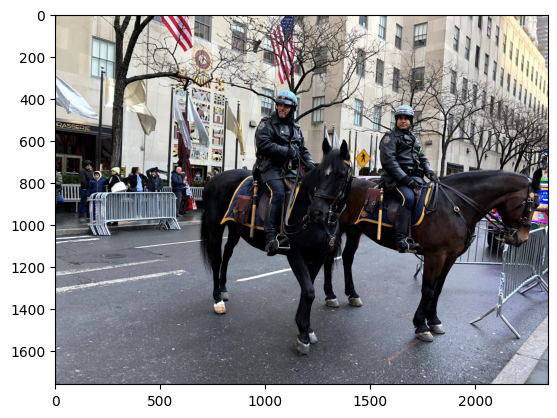

In [4]:
# Load an image

image = Image.open(image_path('street.jpg')).convert('RGB')
show_image(image)

In [5]:
# Resize the image with pads to fit in the model input shape

w_scale, h_scale, data = get_padded_image(ssd_detection, image)

In [6]:
# Let's make sure that the shape of the data is matched to the that of the model input.

print(ssd_detection.input(0).shape)
print(data.shape)

(1, 300, 300, 3)
(1, 300, 300, 3)


In [7]:
%%time
# Run a prediction task
outputs = ssd_detection.run(data)

CPU times: user 12.6 ms, sys: 4.05 ms, total: 16.6 ms
Wall time: 15.9 ms


In [8]:
# This model has 4 output tensors. Please refer to the description of output tensors at 
# https://www.tensorflow.org/lite/models/object_detection/overview
len(outputs)

4

### Postprocessing

Let's draw:
1. the rectangles with labels according to the locations, 
1. classification IDs
1. scores from the output tensors

You can learn more about the details about output tensors from https://www.tensorflow.org/lite/models/object_detection/overview#output_signature

person: 98% (box: 1542, 415, 1807, 1143)
horse: 96% (box: 709, 559, 1479, 1578)
horse: 94% (box: 1209, 645, 2303, 1578)
person: 87% (box: 898, 294, 1203, 1161)
person: 72% (box: 426, 726, 491, 851)
person: 65% (box: 290, 729, 359, 844)
person: 50% (box: 561, 722, 638, 906)


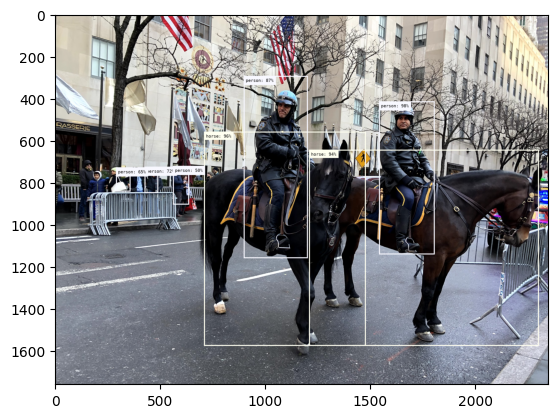

In [9]:
ssd_objects = get_output(ssd_detection, outputs, 0.5, (w_scale, h_scale))
ssd_labels = load_labels('coco_labels.txt')
draw_objects(ImageDraw.Draw(image), ssd_objects, ssd_labels)
show_image(image)
print_objects(ssd_labels, ssd_objects)

In [10]:
ssd_detection.close()

2023-04-13T23:46:14.924095Z  INFO nux::npu: NPU (npu0pe0-1) has been destroyed
2023-04-13T23:46:14.924479Z  INFO nux::capi: session has been destroyed
